____
__Universidad Tecnológica Nacional, Buenos Aires__<br/>
__Ingeniería Industrial__<br/>
__Cátedra de Ciencia de Datos - Curso I5521 - Turno sabado mañana__<br/>
__Elaborado por: Santiago Chas__<br/>
__Editado por: Nicolas Aguirre__
____

# Google Colaboratory

In [8]:
# Verificamos si estamos en Colab
var_google_colab = 'google.colab' in str(get_ipython())
print(var_google_colab)
if var_google_colab:
  #Montamos nuestro G.Drive
  from google.colab import drive
  drive.mount('/content/gdrive',force_remount=True)
  # Direccion root donde está la jupyter-notebook
  root_path = "/content/gdrive/My Drive/Colab Notebooks/ClusterAI/clusterai_2022/clase04/"
  # Direccion donde guardaremos las imagenes
  plot_path = root_path
else:
  # Si, no estamos en google colab, es que estamos corriendo la 
  # en local.
  root_path = ""
  plot_path = root_path  

False


# Titanic Dataset 

Link: https://www.kaggle.com/c/titanic

## Descripción
|Variable |	Definition |	Key |
| --- | --- | --- |
|survival|	Survival|	0 = No, 1 = Yes|
|pclass|	Ticket class|	1 = 1st, 2 = 2nd, 3 = 3rd|
|sex|	Sex	| |
|Age|	Age in years| |	
|sibsp|	# of siblings / spouses aboard the Titanic| |	
|parch|	# of parents / children aboard the Titanic| |	
|ticket|	Ticket number | |	
|fare|	Passenger fare |	|
|cabin|	Cabin number	| |
|embarked|	Port of Embarkation	|C = Cherbourg, Q = Queenstown, S = Southampton

**Objetivo: Clasificar las tres especies de flores segun los datos**

In [9]:
# Importamos algunas de las librerias
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [10]:
# Cargamos el dataset
titanic_df = pd.read_csv(root_path+"train.csv")
# Observamos una parte de los datos
titanic_df.tail(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.00,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.00,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.45,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.00,C148,C
890,891,0,3,"Dooley, Mr. Patrick",male,32.0,0,0,370376,7.75,NaN,Q


In [11]:
#Eliminamos columnas que no nos interesan
titanic_df = titanic_df.drop(['PassengerId',"Name", "Ticket","Cabin"],axis=1)
titanic_df.tail(5)

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
886,0,2,male,27.0,0,0,13.00,S
887,1,1,female,19.0,0,0,30.00,S
888,0,3,female,NaN,1,2,23.45,S
889,1,1,male,26.0,0,0,30.00,C
890,0,3,male,32.0,0,0,7.75,Q


In [12]:
total = titanic_df.isnull().sum().sort_values(ascending=False)
percent = (titanic_df.isnull().sum()/titanic_df.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(6)

,Total,Percent
Age,177,0.198653
Embarked,2,0.002245
Survived,0,0.000000
Pclass,0,0.000000
Sex,0,0.000000
SibSp,0,0.000000


In [13]:
list_a = ['S','Q','C']
titanic_df.loc[~titanic_df['Embarked'].isin(list_a),:]

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
61,1,1,female,38.0,0,0,80.0,NaN
829,1,1,female,62.0,0,0,80.0,NaN


In [14]:
# Lleno vacíos de age con edad promedio
#titanic_df['Age'].fillna(titanic_df['Age'].mean(), inplace = True)
# Lleno Embarked vacíos con "S"
titanic_df['Embarked'].fillna('S', inplace = True)
# chequeamos que todo esta con los NaN
total = titanic_df.isnull().sum().sort_values(ascending=False)
percent = (titanic_df.isnull().sum()/titanic_df.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(6)

,Total,Percent
Age,177,0.198653
Survived,0,0.000000
Pclass,0,0.000000
Sex,0,0.000000
SibSp,0,0.000000
Parch,0,0.000000


-------------------------------------
# EDA

**Tarea**:

* Imprimir la matriz de correlación

* Histograma y Boxplot por Edad segun "Supervivencia"

* Boxplot para ver Edad en función de la clase (Pclass).


-----------------------------------


# Machine Learning Workflow

In [63]:
# Prepocessing & Utils.
import sklearn
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder,MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, GridSearchCV
#Metricas
from sklearn.metrics import accuracy_score,roc_curve, auc,confusion_matrix
# Modelos
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

## Dataset

In [16]:
# Definimos las variables de entrenamiento y objetivo.
features = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare','Embarked']
target = ['Survived']
# Generamos X e Y
X = titanic_df.loc[:,features]
Y = titanic_df.loc[:,target]

# Spliteamos Train y test
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0)

## Pipeline y ColumnTransformer


Vamos a continuar con la implementacion del workflow ede trabajo de ML incorporando dos herramientas.

* [Pipeline](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html#sklearn.pipeline.Pipeline)


Pipeline aplica secuencialmente una lista de transformaciones y un estimador final. 

Los pasos (*steps*) intermedios de la cadena deben ser "transformadores", es decir, deben implementar los métodos **.fit()** y **transform**. 

* [ColumnTransformer](https://scikit-learn.org/stable/modules/generated/sklearn.compose.ColumnTransformer.html)

ColumnTransformer aplica transformadores a las columnas de un array o DataFrame de pandas.

Este estimador permite transformar diferentes columnas o subconjuntos de columnas de la entrada por separado y las características generadas por cada transformador se concatenarán para formar un único espacio de características. 

Esto es útil para datos heterogéneos o columnares, para combinar varios mecanismos de extracción de características o transformaciones en un solo transformador.

In [17]:
# Diferenciemos los tipos de variables (numericas, categoricas)
varaibles_num_1 = ["Age", "Fare"]
varaibles_num_2 = ["SibSp","Parch"]
variables_cat = ["Embarked", "Sex", "Pclass"]

In [18]:
# Definamos las transformaciones para cada tipo de variable:
transformacion_num_1 = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="median")), ("scaler", StandardScaler())]
)

transformacion_num_2 = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="mean")), ("scaler", MinMaxScaler())]
)

transformacion_cat = OneHotEncoder(handle_unknown="error")

In [19]:
# Juntemos todo:
preprocesamiento = ColumnTransformer(
    # (nombre,transformacion, columnas )
    transformers=[ 
        ("num1", transformacion_num_1, varaibles_num_1),
        ("num2", transformacion_num_2, varaibles_num_2),
        ("cat", transformacion_cat, variables_cat),
    ]
)

 Veamos que nos devuelve hasta aca el preprocesamiento ...

In [20]:
pd.DataFrame(preprocesamiento.fit_transform(X_train), columns=preprocesamiento.get_feature_names_out())

,num1__Age,num1__Fare,num2__SibSp,num2__Parch,cat__Embarked_C,cat__Embarked_Q,cat__Embarked_S,cat__Sex_female,cat__Sex_male,cat__Pclass_1,cat__Pclass_2,cat__Pclass_3
0,-0.045676,-0.331679,0.000,0.333333,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
1,0.107186,-0.426405,0.000,0.000000,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
2,0.107186,0.102620,0.125,0.166667,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
3,-0.733559,-0.555896,0.000,0.000000,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
4,-0.657127,-0.491276,0.000,0.000000,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
707,0.718637,1.023857,0.125,0.166667,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
708,-0.809990,-0.479216,0.125,0.000000,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0
709,-0.045676,-0.481629,0.000,0.000000,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
710,0.489343,-0.288681,0.125,0.000000,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0


Bien, ya tenemos el preprocesamiento consolidado ...

Utilicemos nuevamente **Pipeline** para agregarle un estimador ... por ejemplo ... **LogisticRegression**.

In [21]:
pipeline = Pipeline(
    steps=[("preprocesamiento", preprocesamiento), ("estimador", LogisticRegression())]
)

Workflow hasta el momento:

In [22]:
from sklearn import set_config
set_config(display="diagram")
pipeline

Pipeline(steps=[('preprocesamiento',
                 ColumnTransformer(transformers=[('num1',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Age', 'Fare']),
                                                 ('num2',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   MinMaxScaler())]),
                                                  ['SibSp', 'Parch']),
                                                 ('cat', OneHotEncoder(),
                                                  ['Embarked', 'Sex',
                                                   'Pclass'])])),
                ('estimador', LogisticRegression())])

# PREGUNTAS ?

## Modelos y sus Hyperparametros

Como sabemos podemos querer comparar muchos modelos ...

Por ejemplo, dado un modelo de SVC hariamos ....

```
#Modelo
svc = SVC()
#Pipeline
pipeline = Pipeline(
    steps=[("preprocesamiento", preprocesamiento), ("estimador", svc)]
    )

# Hyperparametros
parameters = {'estimador__kernel':('linear', 'rbf'),
              'estimador__C':[1, 10, 100],
              'estimador__gamma':[0.001, 0.1,1, 10]}
# GridhSearchCV
clf = GridSearchCV(pipeline, # pipeline
                   param_grid = parameters, # Hyperparametros
                   refit = True, # refit nos devuelve el modelo con los mejores parametros encontrados 
                   cv = 5, # cv indica la cantidad de folds
                   verbose=1)
#Fit
clf.fit(X_train, Y_train.values.ravel())

```

Y para un modelo distinto, tendriamso que definir un nuevo modelo, pasarselo a Pipiline ...etc, etc, etc ...

![blablabla](https://i.giphy.com/media/bTvrXKt7qoALMMklz4/giphy.webp)


Pero lo que queremos es poder compactar **todo**:

* Pipeline

* ColumnTransformer

* Models

* GridSearchCV

In [30]:
# Ya tenemos CASI todo ... solo nos falta definir los modelos y sus hyperparametros

# ATENCION: "__" (son dos "_" seguidos) se usa como indicador de features del estimador. 

parametros = [
    {
        "estimador": (LogisticRegression(),),
          "estimador__C": (0.001,1,10)
    }, 
    {
        "estimador": (RandomForestClassifier(),),
        "estimador__n_estimators": [50, 100], 
        "estimador__max_features": [3, 8], 
        "estimador__max_depth": [5, 20, 50], 
        "estimador__min_samples_leaf":[ 8, 10]
    },
    {
        "estimador": (SVC(),),
          "estimador__kernel":('linear', 'rbf'), 
          "estimador__C":(1, 10, 100), 
          "estimador__gamma":(0.001, 0.01, 0.1,1, 10)          
    }
]

In [62]:
# Creamos el GSCV: 
grid_search = GridSearchCV(pipeline, parametros,
                  refit = True, # refit nos devuelve el modelo con los mejores parametros encontrados 
                   cv = 5, # cv indica la cantidad de folds
                   verbose=1)

## Fitting !

In [32]:
grid_search.fit(X_train, Y_train.values.ravel())

Fitting 5 folds for each of 57 candidates, totalling 285 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocesamiento',
                                        ColumnTransformer(transformers=[('num1',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['Age',
                                                                          'Fare']),
                                                                        ('num2',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer()),
                                                                                         ('scaler',
                                                                                          MinMaxScaler())]),
                                                                         ['SibSp',
                                                                          'Parch']),
                                                                        ('cat',
                                                                         OneHotEncoder(),
                                                                         ['Embarked',
                                                                          'Sex'...
                         {'estimador': (RandomForestClassifier(max_depth=50,
                                                               max_features=8,
                                                               min_samples_leaf=8),),
                          'estimador__max_depth': [5, 20, 50],
                          'estimador__max_features': [3, 8],
                          'estimador__min_samples_leaf': [8, 10],
                          'estimador__n_estimators': [50, 100]},
                         {'estimador': (SVC(),), 'estimador__C': (1, 10, 100),
                          'estimador__gamma': (0.001, 0.01, 0.1, 1, 10),
                          'estimador__kernel': ('linear', 'rbf')}],
             verbose=1)

In [33]:
# Toda la informacion del entrenamiento esta en cv_results_
scores = grid_search.cv_results_
#Veamosla ...
scores_df = pd.DataFrame.from_dict(scores)
scores_df.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_estimador,param_estimador__C,param_estimador__max_depth,param_estimador__max_features,param_estimador__min_samples_leaf,param_estimador__n_estimators,...,param_estimador__kernel,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.056060,0.019122,0.016001,0.004476,LogisticRegression(),0.001,NaN,NaN,NaN,NaN,...,NaN,"{'estimador': LogisticRegression(), 'estimador...",0.622378,0.615385,0.633803,0.619718,0.612676,0.620792,0.007322,57
1,0.030888,0.003158,0.009644,0.001190,LogisticRegression(),1,NaN,NaN,NaN,NaN,...,NaN,"{'estimador': LogisticRegression(), 'estimador...",0.755245,0.825175,0.767606,0.795775,0.830986,0.794957,0.030123,31
2,0.035181,0.002495,0.010495,0.000987,LogisticRegression(),10,NaN,NaN,NaN,NaN,...,NaN,"{'estimador': LogisticRegression(), 'estimador...",0.762238,0.818182,0.746479,0.788732,0.838028,0.790732,0.033955,32
3,0.116463,0.016832,0.016517,0.001006,"RandomForestClassifier(max_depth=50, max_featu...",NaN,5,3,8,50,...,NaN,{'estimador': RandomForestClassifier(max_depth...,0.776224,0.867133,0.774648,0.795775,0.823944,0.807545,0.034703,16
4,0.202425,0.014345,0.021642,0.001604,"RandomForestClassifier(max_depth=50, max_featu...",NaN,5,3,8,100,...,NaN,{'estimador': RandomForestClassifier(max_depth...,0.776224,0.867133,0.774648,0.795775,0.830986,0.808953,0.035474,14


In [36]:
print("The best parameters are %s with a score of %0.2f" % (grid_search.best_params_, grid_search.best_score_))

The best parameters are {'estimador': RandomForestClassifier(max_depth=50, max_features=8, min_samples_leaf=8), 'estimador__max_depth': 50, 'estimador__max_features': 8, 'estimador__min_samples_leaf': 8, 'estimador__n_estimators': 100} with a score of 0.82


## Predict

In [64]:
pd.DataFrame(preprocesamiento.transform(X_test), columns=preprocesamiento.get_feature_names_out())

,num1__Age,num1__Fare,num2__SibSp,num2__Parch,cat__Embarked_C,cat__Embarked_Q,cat__Embarked_S,cat__Sex_female,cat__Sex_male,cat__Pclass_1,cat__Pclass_2,cat__Pclass_3
0,-0.045676,-0.347398,0.000,0.000000,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
1,-0.045676,-0.485288,0.000,0.000000,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
2,-1.727166,-0.054650,0.500,0.166667,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
3,-0.045676,2.288576,0.125,0.000000,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
4,-0.045676,-0.331679,0.000,0.333333,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
174,-1.268578,-0.491691,0.000,0.000000,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
175,-0.045676,-0.475308,0.000,0.000000,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
176,0.107186,1.624988,0.125,0.000000,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
177,-0.504265,-0.479216,0.000,0.000000,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0


In [37]:
# Prediction sobre las muestras de test
Y_pred = grid_search.predict(X_test)
print(Y_pred)

[0 0 0 1 0 0 1 1 0 1 0 1 0 1 1 1 0 0 0 1 0 1 0 0 1 1 0 1 1 0 0 1 0 0 0 0 0
 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 1 0 1 0 1 1 1 0 0 0
 0 1 0 0 0 0 0 0 1 0 0 1 1 0 1 0 0 0 1 1 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 1 0
 1 0 0 0 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 1 1 1 0 1
 1 0 0 0 0 0 1 0 0 0 1 1 0 0 1 0 0 0 0 0 0 0 0 1 0 0 1 0 1 0 0]


## Results

In [57]:
# Computo el accuracy (comparar ytest vs ypred)
test_acc = accuracy_score(Y_test, Y_pred)
print("El accuracy es " + str(test_acc))

El accuracy es 0.8268156424581006


In [58]:
# Compute and plot AUC
Y_proba = grid_search.predict_proba(X_test)
fpr1, tpr1, thresholds = roc_curve(Y_test.astype('int'), Y_proba[:,1], drop_intermediate = False)
auc_value = auc(fpr1, tpr1)
print("El AUC es = " + str(auc_value))

El AUC es = 0.8926877470355732


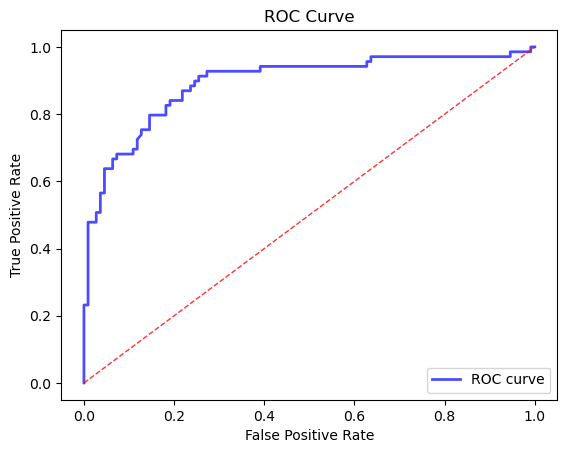

In [65]:
plt.plot(fpr1, tpr1, lw=2, alpha=0.7 , label = 'ROC curve', color = 'b')
plt.plot([0, 1], [0, 1], linestyle='--', lw=1, color='r', alpha=.8)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(False)
plt.legend(loc="lower right")
plt.title('ROC Curve')
plt.show()

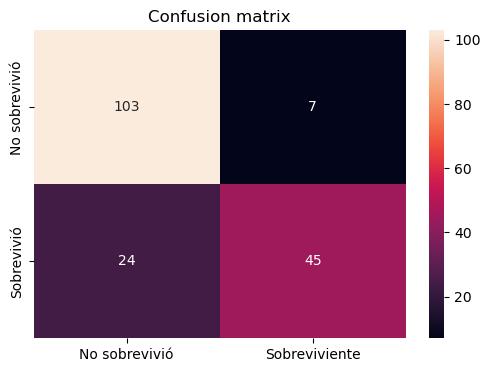

In [66]:
# Compute Confusion Matrix
cm = confusion_matrix(Y_test, Y_pred)
df_cm = pd.DataFrame(cm, index = ['No sobrevivió', 'Sobrevivió'], columns = ['No sobrevivió', "Sobreviviente"])
plt.figure(figsize = (6,4))
sns.heatmap(df_cm, annot=True,fmt='g')
plt.title('Confusion matrix')
plt.show()

# PREGUNTAS?

![meme](https://pythonprogramming.net/static/images/svm/machineLearning.png)